<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук ВШЭ, программист-исследователь Mail.ru Group  Юрий Кашницкий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 7. Задача Обучение без учителя
## <center>Практика. Кластеризация данных с акселерометров и гироскопов мобильных телефонов

**Считываем <a href="https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones">данные</a> Samsung Human Activity Recognition. Они же есть [тут](https://yadi.sk/d/ha-lprkDvozGx).**

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

**Считаем данные, объединим обучающую и тестовую выборки. Метки целевого класса будем использовать для оценки качества кластеризации. Конечно, kMeans не будет ничего о них "знать".**

In [2]:
X_train = np.loadtxt("../../data/samsung_train.txt") 
X_test = np.loadtxt("../../data/samsung_test.txt") 

y_train = np.loadtxt("../../data/samsung_train_labels.txt").astype(int)
y_test = np.loadtxt("../../data/samsung_test_labels.txt").astype(int)

**Для кластеризации объединим выборки.**

In [3]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

In [4]:
X.shape

(10299, 561)

**Опеределим число уникальных значений меток целевого класса. Эти метки соответствуют ходьбе (1), подъему вверх по лестнице (2), спуску по лестнице (3), сидению (4), стоянию (5) и лежанию (6). [Описание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)**

In [5]:
n_classes = len(np.unique(y))
n_classes

6

**Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить 90% дисперсии.**

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_pca = PCA(n_components=0.9).fit_transform(X_scaled)
X_pca.shape

(10299, 65)

**Визуализируем данные в проекции на первые две главные компоненты. Отчетливо выделяются 2 группы активностей. Можно догадаться, какие именно.**

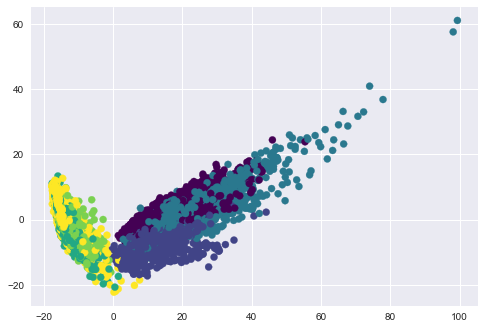

In [8]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=50, cmap='viridis');

**Сделайте кластеризацию данных методом KMeans. Задайте параметр *n_clusters*, равный *n_classes* - найденному ранее числу уникальных меток целевого класса.**

In [9]:
%%time
kmeans = KMeans(n_clusters=n_classes, n_init=100)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

CPU times: user 29.4 s, sys: 418 ms, total: 29.8 s
Wall time: 7.48 s


**Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответсвии с полученными метками кластеров.**

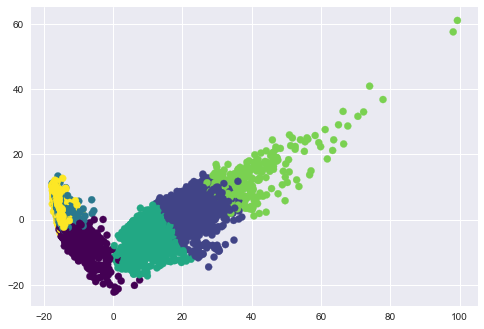

In [11]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=50,  cmap='viridis');

**Посмотрите на соответствие между метками кластеров и исходными метками классов. Посмотрите, какие виды активностей алгоритм KMeans путает.**

In [12]:
from pandas import crosstab
tab = crosstab(y, cluster_labels, margins=True)
tab.index = ['walk', 'up', 'down', 'sit', 'stand', 'lay', 'all']
tab.columns = ['cluster' + str(i) for i in range(n_classes)] + ['all']
tab

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,all
walk,0,741,0,903,78,0,1722
up,2,296,0,1241,5,0,1544
down,0,890,0,320,196,0,1406
sit,450,0,1235,1,0,91,1777
stand,562,0,1344,0,0,0,1906
lay,329,0,52,5,0,1558,1944
all,1343,1927,2631,2470,279,1649,10299


**Посчитайте метрики качества кластеризации ARI, AMI, гомогенность, полноту и силуэт.**

In [13]:
from sklearn import metrics

print('ARI =', metrics.adjusted_rand_score(y, cluster_labels))
print('AMI =', metrics.adjusted_mutual_info_score(y, cluster_labels))
print('Homogeneity =', metrics.homogeneity_score(y, cluster_labels))
print('Completeness =', metrics.completeness_score(y, cluster_labels))
print('V-measure =', metrics.v_measure_score(y, cluster_labels))
print('Silhouette =', metrics.silhouette_score(X_pca, cluster_labels, 
                                               metric='euclidean'))

ARI = 0.41980700126
AMI = 0.540444964433
Homogeneity = 0.540757811646
Completeness = 0.581157977046
V-measure = 0.560230489767
Silhouette = 0.14150241544


**Видно, что kMeans хорошо отличает только группы активностей – 1 группа: walk, walk up, walk down, 2 группа: sit, stand, lay. Попробуйте искать не 6, а 2 кластера. Посмотрите теперь на качество кластеризации и прокомментируйте результат.**

In [14]:
y_walk = (y <= 3).astype('int')

In [15]:
%%time
two_clusters_labels = KMeans(n_clusters=2, n_init=100).fit_predict(X)

CPU times: user 39.4 s, sys: 2.5 s, total: 41.9 s
Wall time: 10.6 s


In [16]:
tab2 = crosstab(y_walk, two_clusters_labels, margins=True)
tab2.index = ['walk/up/down', 'sit/stand/lay', 'all']
tab2.columns = ['cluster1', 'cluster2', 'all']
tab2

,cluster1,cluster2,all
walk/up/down,15,5612,5627
sit/stand/lay,4672,0,4672
all,4687,5612,10299


In [17]:
print('ARI =', metrics.adjusted_rand_score(y_walk, two_clusters_labels))
print('AMI =', metrics.adjusted_mutual_info_score(y_walk, two_clusters_labels))
print('Homogeneity =', metrics.homogeneity_score(y_walk, two_clusters_labels))
print('Completeness =', metrics.completeness_score(y_walk, two_clusters_labels))
print('V-measure =', metrics.v_measure_score(y_walk, two_clusters_labels))
print('Silhouette =', metrics.silhouette_score(X_pca, two_clusters_labels, 
                                               metric='euclidean'))

ARI = 0.994181717508
AMI = 0.985360762934
Homogeneity = 0.985743163841
Completeness = 0.985361794437
V-measure = 0.985552442245
Silhouette = 0.435776089297


### Многоклассовая классификация
Видим, что выделять 6 кластеров на этих данных хорошо не получается. Хорошо отделяются только ходьба (простая, вверх и вниз) от остальных активностей. Зато задача неплохо решается как задача классификации.

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(0.9)
X_train_pca = pca.fit_transform(X_train_scaled)
print(X_train_pca.shape)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
print(X_test_pca.shape)

(7352, 63)
(2947, 63)


**Будем обучать лес на исходных признаках и на 63 главных компонентах.**

In [20]:
forest = RandomForestClassifier(n_estimators=100, 
                                random_state=7, n_jobs=-1,
                                oob_score=True)
forest_pca = RandomForestClassifier(n_estimators=100, 
                                random_state=7, n_jobs=-1,
                                oob_score=True)

**Обучите лес на 63 главных компонентах.**

In [21]:
%%time
forest_pca.fit(X_train_pca, y_train);

CPU times: user 6.16 s, sys: 26.5 ms, total: 6.19 s
Wall time: 1.02 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=7,
            verbose=0, warm_start=False)

In [22]:
forest_pca.oob_score_

0.92736670293797607

**Обучите лес на всех признаках.**

In [23]:
%%time
forest.fit(X_train, y_train);

CPU times: user 16 s, sys: 131 ms, total: 16.1 s
Wall time: 2.51 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=7,
            verbose=0, warm_start=False)

In [24]:
forest.oob_score_

0.98299782372143629

**Сравните качество (долю правильных ответов и F1 с макро-усреднением) на тестовой выборке для леса, обученного на всех признаках, и для леса, обученного на 63 главных компонентах. Посмотрите также на матрицы ошибок.**

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [26]:
forest_pca_pred = forest_pca.predict(X_test_pca)
print(accuracy_score(y_test, forest_pca_pred))
print(f1_score(y_test, forest_pca_pred, average='macro'))

0.874787919919
0.871158219546


In [27]:
confusion_matrix(y_test, forest_pca_pred)

array([[474,   1,  21,   0,   0,   0],
       [ 33, 425,  13,   0,   0,   0],
       [ 62,  46, 312,   0,   0,   0],
       [  0,   1,   0, 367, 121,   2],
       [  0,   0,   0,  42, 490,   0],
       [  0,   0,   0,  25,   2, 510]])

In [28]:
forest_pred = forest.predict(X_test)
print(accuracy_score(y_test, forest_pred))
print(f1_score(y_test, forest_pred, average='macro'))

0.925347811334
0.923445482443


In [29]:
confusion_matrix(y_test, forest_pred)

array([[481,   8,   7,   0,   0,   0],
       [ 41, 424,   6,   0,   0,   0],
       [ 21,  42, 357,   0,   0,   0],
       [  0,   0,   0, 434,  57,   0],
       [  0,   0,   0,  38, 494,   0],
       [  0,   0,   0,   0,   0, 537]])

**Проверьте аналогично линейный SVM на всех признаках. Настройте параметр C с помощью GridSearchCV.**

In [30]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [31]:
svm = LinearSVC()
svm_params = {'C': np.logspace(-2, 2, 10)}

In [32]:
best_svm = GridSearchCV(svm, svm_params,
                       n_jobs=-1, cv=3, verbose=True)

In [33]:
%%time
best_svm.fit(X_train_scaled, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.1s finished


CPU times: user 5.97 s, sys: 123 ms, total: 6.09 s
Wall time: 29.5 s


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   2.78256e-02,   7.74264e-02,   2.15443e-01,
         5.99484e-01,   1.66810e+00,   4.64159e+00,   1.29155e+01,
         3.59381e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [34]:
best_svm.best_score_

0.93824809575625678

In [35]:
svm_pred = best_svm.predict(X_test_scaled)
print(accuracy_score(y_test, svm_pred))
print(f1_score(y_test, svm_pred, average='macro'))

0.962673905667
0.963562633012


In [36]:
confusion_matrix(y_test, svm_pred)

array([[493,   2,   0,   1,   0,   0],
       [ 13, 457,   1,   0,   0,   0],
       [  2,   3, 414,   1,   0,   0],
       [  0,   4,   0, 431,  56,   0],
       [  0,   0,   0,  16, 516,   0],
       [  0,   0,   0,   0,  11, 526]])